In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

import imagesize
from tqdm import tqdm

from abc import ABC,abstractmethod

from typing_extensions import Union
from typing import Tuple

from random import choice
from random import seed

from PIL import ImageEnhance,Image,ImageOps

# SAVING IMAGES INFORMATION IN CSV

In [3]:
class save_data(ABC):

    @abstractmethod
    def save_dataframe(self)->None:
        pass

In [4]:
class create_csv(save_data):

    def __init__(self , images_path:str , save_path:str):
        self.images_path = images_path
        self.save_path = save_path

    def extract_dimensions(self,image_path:str)->Union[int,int]:
        width,height = imagesize.get(image_path)
        return width,height
    
    def extract_features(self)->pd.DataFrame:
        categories = os.listdir(self.images_path)
        images_features = []

        for category in categories:
            for image in tqdm(os.listdir(f'../data/images/{category}')):
                
                image_path = f"../data/images/{category}/{image}"
                width , height = self.extract_dimensions(image_path)
                
                image_feature = {}
                image_feature["name"] = image
                image_feature["width"] = width
                image_feature["height"] = height
                image_feature["category"] = category
                images_features.append(image_feature)

        return pd.DataFrame(images_features)

    
    def save_dataframe(self)->None:
        dataframe = self.extract_features()
        dataframe.to_csv(self.save_path)
        return

In [7]:
images_path = '../data/images'
save_path = '../data/data.csv'

In [5]:

save_csv_data = create_csv(images_path=images_path,save_path=save_path)
save_csv_data.save_dataframe()

100%|██████████| 1484/1484 [00:08<00:00, 166.60it/s]


<br/>
<br/>
<br/>

### ANALYZING THE DATA

In [8]:
df = pd.read_csv(save_path)
df.drop(['Unnamed: 0'],axis=1,inplace=True)
df.head()

,name,width,height,category
0,person100_bacteria_475.jpeg,1106,762,BAC_PNEUMONIA
1,person100_bacteria_477.jpeg,1024,680,BAC_PNEUMONIA
2,person100_bacteria_478.jpeg,1128,624,BAC_PNEUMONIA
3,person100_bacteria_479.jpeg,904,552,BAC_PNEUMONIA
4,person100_bacteria_480.jpeg,880,536,BAC_PNEUMONIA


In [7]:
df.describe()

,width,height
count,4448.000000,4448.000000
mean,1356.598696,1007.124101
std,372.069271,398.125204
min,384.000000,127.000000
25%,1072.000000,704.000000
50%,1311.000000,932.000000
75%,1596.000000,1245.000000
max,2916.000000,2713.000000


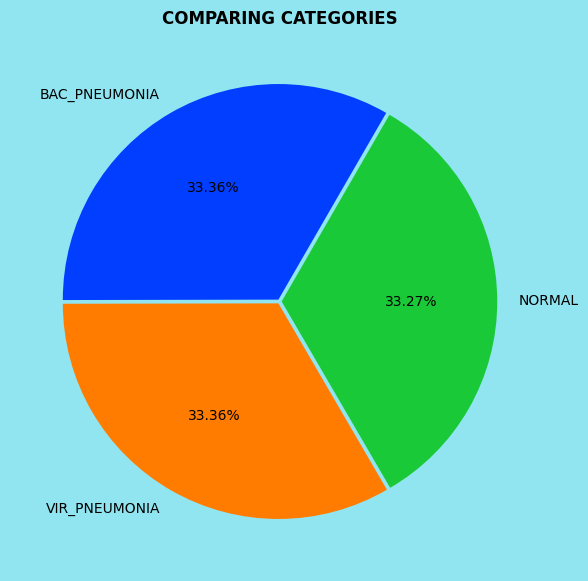

In [198]:
def comparing_categories( df : Union[ pd.DataFrame , pd.Series ] ) -> None :
    
    categories = df['category'].value_counts().index 
    data = df['category'].value_counts().values
    
    plt.figure(figsize=(7,7),facecolor="#90E5F1")
    plt.pie( 
            data , labels = categories , 
            autopct = '%1.2f%%' , 
            colors = sns.color_palette('bright'),
            explode = [0.01 for i in categories],
            startangle = 60
            )

    plt.title("COMPARING CATEGORIES",weight='bold')
    plt.show();


comparing_categories(df)

<br/>
<br/>
<br/>

### ANALYZING IMAGES

In [9]:
df['category'].value_counts().index

Index(['BAC_PNEUMONIA', 'VIR_PNEUMONIA', 'NORMAL'], dtype='object')

In [14]:
class EDA(ABC):

    @abstractmethod
    def visualize_image(self,ax,index):
        pass

    @abstractmethod
    def image_histogram(self,ax,index):
        pass

    @abstractmethod
    def binary_image(self,ax,index):
        pass

    @abstractmethod
    def binary_image_barplot(self,ax,index):
        pass

    @abstractmethod
    def enhance_image(self):
        pass

    @abstractmethod
    def plot_equalized_image(self,ax,index):
        pass
    
    @abstractmethod
    def equalized_image_histogram(self,ax,index):
        pass
    
    @abstractmethod
    def visualizations_pipeline(self):
        pass


Int64Index([1484, 1485, 1486, 1487, 1488, 1489, 1490, 1491, 1492, 1493,
            ...
            2954, 2955, 2956, 2957, 2958, 2959, 2960, 2961, 2962, 2963],
           dtype='int64', length=1480)

In [15]:
class Visualization(EDA):

    def __init__( self , dataframe:Union[pd.DataFrame,pd.Series] , new_size:Tuple[int,int] , threshold:int=125 , random_seed:int = None ,  BRIGHTNESS_FACTOR:float=1 , SATURATION_FACTOR:float=1 , CONTRAST_FACTOR:float=1 , SHARPNESS_FACTOR:float = 1 ):
        self.df = dataframe
        self.categories = df['category'].value_counts().index 
        self.threshold = threshold
        self.random_seed = random_seed
        self.new_size = new_size

        self.BRIGHTNESS_FACTOR = BRIGHTNESS_FACTOR
        self.SATURATION_FACTOR = SATURATION_FACTOR
        self.CONTRAST_FACTOR = CONTRAST_FACTOR
        self.SHARPNESS_FACTOR = SHARPNESS_FACTOR

        self.binary_images = None
        self.gray_images = None
        self.equalized_images = None
        self.indexes = None

    
    def get_indexes( self )->None:
        self.indexes = []
        seed(self.random_seed)
        for category in self.categories:
            self.indexes.append(choice(df[df["category"]==category]["category"].index)) 
        return
    

    def fetch_images( self )->None:
        self.gray_images = []
        self.binary_images = []
        self.equalized_images = []
        BASE_PATH = '../data/images'

        for i in range(len(self.indexes)):
            image_name = df["name"][self.indexes[i]]
            image_path = f"{BASE_PATH}/{self.categories[i]}/{image_name}"
            
            image = Image.open(image_path)
            # For converting the image to grayscale image
            image = image.convert("L")
            image = image.resize(self.new_size)

            equalized_image = ImageOps.equalize(image , mask=None)
            self.equalized_images.append(np.array(equalized_image))

            image = np.array(image)
            
            self.gray_images.append(image)
            binary_image = np.where( image < self.threshold , 0 , 1 )
            self.binary_images.append(binary_image)
            



    def visualize_image(self, ax:plt.Axes , index:int)->plt.plot:
        ax.axis(False)
        ax.set_title( self.categories[index] , fontweight='bold', size=18 )
        plot = ax.imshow( self.gray_images[index] , cmap='gray' )
        return plot
    
    

    def image_histogram(self, ax:plt.Axes , index:int)->plt.plot:
        image = np.reshape(self.gray_images[index],(self.gray_images[index].shape[0]*self.gray_images[index].shape[1]))
        plot = sns.histplot(data = image , binwidth=25 , ax=ax , element='step')
        ax.set_xlabel("IMAGE PIXELS")
        ax.set_ylabel("PIXEL MAGNITUDES")
        ax.set_title("Image Histogram")
        return plot
    

    def binary_image(self,ax:plt.Axes,index:int)->plt.plot:
        ax.axis(False)
        plot = ax.imshow(self.binary_images[index],cmap='gray')
        return plot


    def binary_image_barplot( self , ax:plt.Axes , index:int ):
        values_counts = np.unique( self.binary_images[index] , return_counts=True )
        x_values = values_counts[0]
        height = values_counts[1] 

        ax.set_xlabel("BINARY IMAGE PIXELS")
        ax.set_ylabel("MAGNITUDES")
        ax.set_xticks([0,1]) 
        ax.set_xticklabels(["0","1"]) 
        ax.set_title("Binary Image Barplot")
        plot = ax.bar(x = x_values , height=height , color=sns.color_palette('bright'))
        return plot



    def change_brightness(self,image):
        brightness_filter = ImageEnhance.Brightness(image)
        output = brightness_filter.enhance(self.BRIGHTNESS_FACTOR)
        return output

    def change_contrast(self,image):
        contrast_filter = ImageEnhance.Contrast(image)
        output = contrast_filter.enhance(self.CONTRAST_FACTOR)
        return output


    def change_saturation(self,image):
        saturation_filter = ImageEnhance.Color(image)
        output = saturation_filter.enhance(self.SATURATION_FACTOR)
        return output


    def change_sharpness(self,image):
        sharpness_filter = ImageEnhance.Sharpness(image)
        output = sharpness_filter.enhance(self.SHARPNESS_FACTOR)
        return output


    def enhance_image( self , ax , index )->plt.plot:
        image = Image.fromarray(self.gray_images[index])
        image = self.change_brightness(image) 
        image = self.change_contrast(image) 
        image = self.change_saturation(image) 
        image = self.change_sharpness(image) 
        ax.axis(False)
        plot = ax.imshow( image , cmap='gray' )
        return plot
                

    def plot_equalized_image( self , ax , index )->plt.plot:
        ax.axis(False)
        plot = ax.imshow( self.equalized_images[index] , cmap='gray' )
        return plot
    

    def equalized_image_histogram( self , ax , index )->plt.plot:
        image = np.reshape(self.equalized_images[index] , ( self.equalized_images[index].shape[0] * self.equalized_images[index].shape[1] ) )
        plot = sns.histplot(data = image , binwidth=25 , ax=ax , element='step')
        ax.set_xlabel("Equalized IMAGE PIXELS")
        ax.set_ylabel("PIXEL MAGNITUDES")
        ax.set_title("Equalized Image Histogram")
        return plot


    def visualizations_pipeline(self):

        self.get_indexes()
        self.fetch_images()

        num_cols = len(self.categories)
        fig,ax = plt.subplots(nrows=7,ncols=num_cols,figsize=(20,20),facecolor="#BCD9FC")
        
        # Plotting images
        for i in range(len(self.indexes)): 
            self.visualize_image(ax[0][i],i)
            
        # Creating image histogram
        for i in range(len(self.indexes)):
            self.image_histogram(ax[1][i],i)

        # Plotting binary images
        for i in range(len(self.indexes)):
            self.binary_image(ax[2][i],i)

        # Plotting binary image histogram
        for i in range(len(self.indexes)):
            self.binary_image_barplot(ax[3][i],i)

        # Changing features like brightness , contrast , sharpness and saturation to enhance the image
        for i in range(len(self.indexes)):
            self.enhance_image(ax[4][i],i)
        
        # Equalization
        for i in range(len(self.indexes)):
            self.plot_equalized_image(ax[5][i],i)
        
        # Equalization Histogram
        for i in range(len(self.indexes)):
            self.equalized_image_histogram(ax[6][i],i)


        fig.tight_layout()
        plt.show()

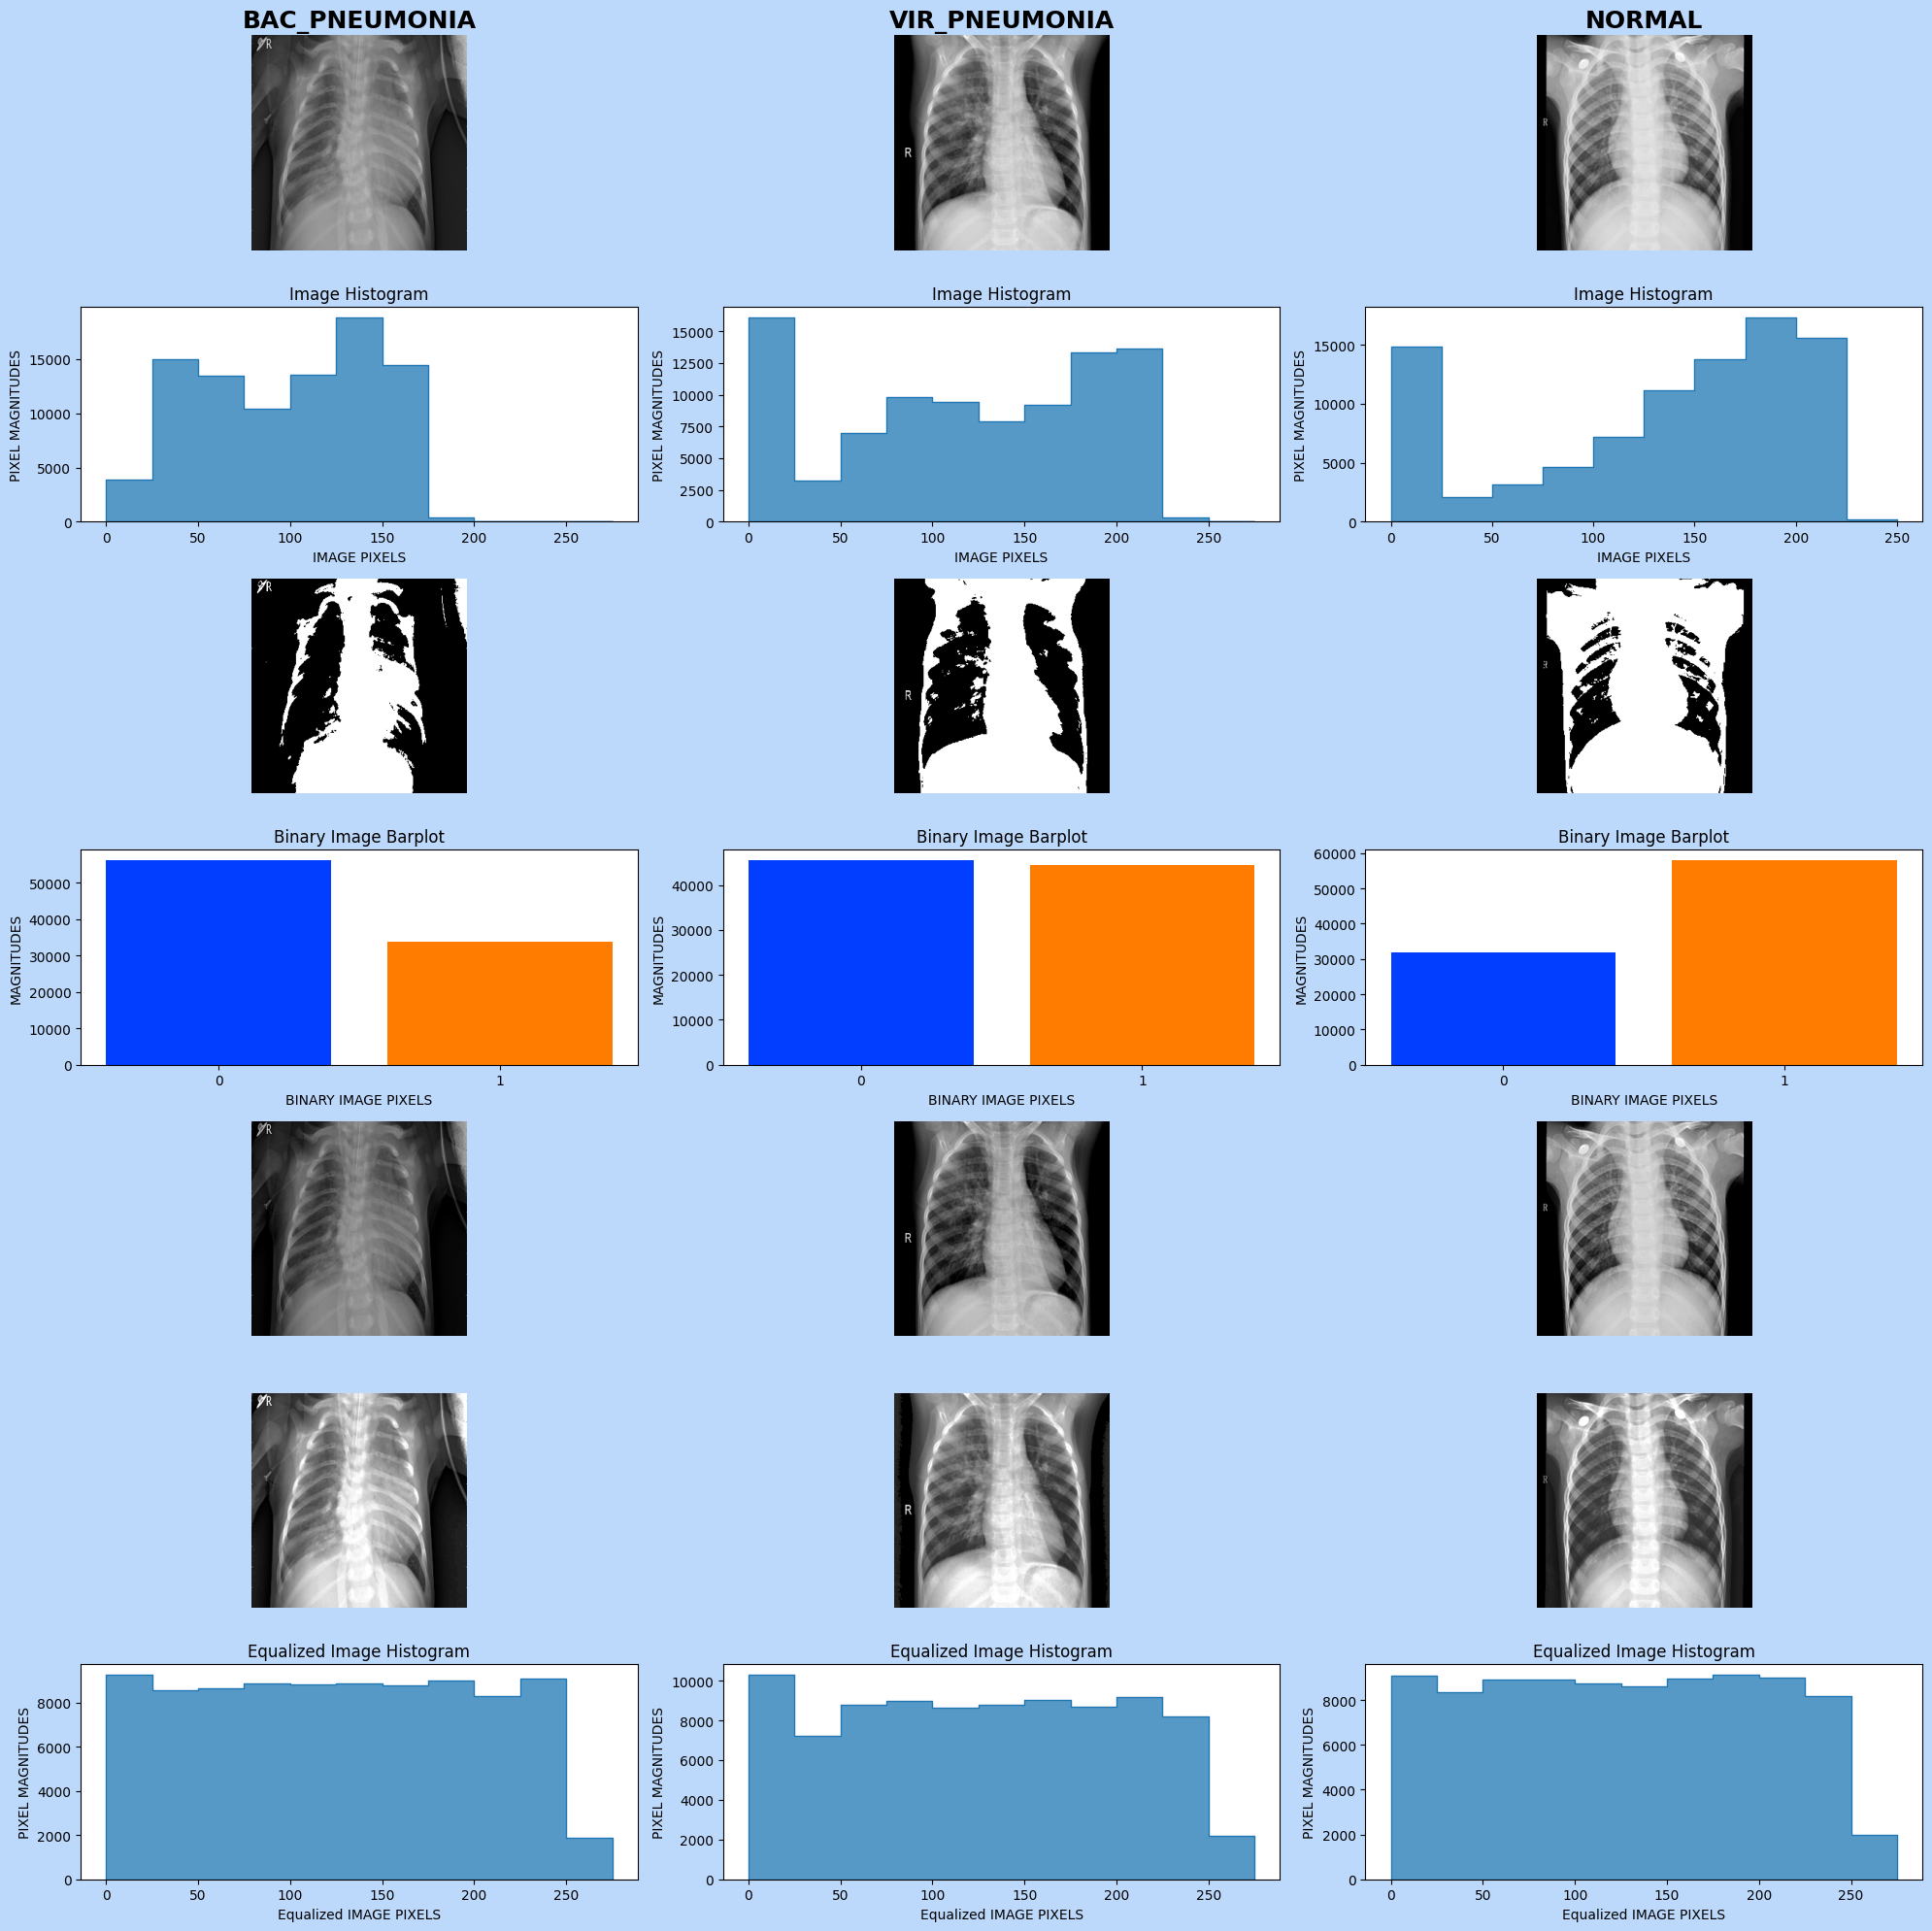

In [16]:
dataframe = df
new_size = (300,300)
threshold = 125
random_seed = None

BRIGHTNESS_FACTOR = 0.8
SATURATION_FACTOR = 1
CONTRAST_FACTOR = 1.3
SHARPNESS_FACTOR = 1.5

visualizations = Visualization(df,(300,300),125,None,BRIGHTNESS_FACTOR,SATURATION_FACTOR,CONTRAST_FACTOR,SHARPNESS_FACTOR)
visualizations.visualizations_pipeline()